In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [3]:
DATA_DIR = '/kaggle/input/jovian-pytorch-z2g/Human protein atlas'



TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/test'                           

TRAIN_CSV = DATA_DIR + '/train.csv'  
TEST_CSV = DATA_DIR + '/train.csv' 

In [4]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [5]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [6]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [7]:
from torch.utils.data import Dataset, random_split, DataLoader

In [8]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [9]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
#     T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
#     T.Normalize(*imagenet_stats,inplace=True), 
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
#     T.Resize(256), 
    T.ToTensor(), 
#     T.Normalize(*imagenet_stats)
])

In [10]:
np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [11]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds), len(val_ds)

(17335, 1901)

In [12]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: Cytosol(6) Plasma membrane(7)


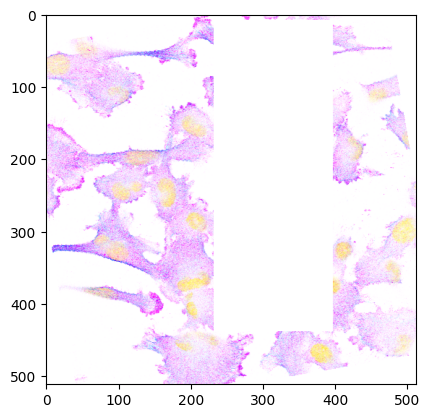

In [13]:
show_sample(*train_ds[1541])

In [14]:
batch_size = 64

In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)

In [16]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

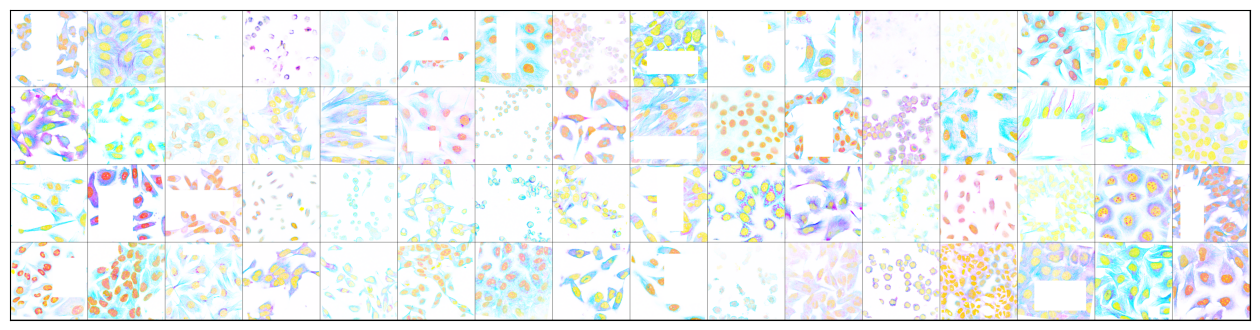

In [17]:
show_batch(train_dl, invert=True)

In [18]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [19]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [20]:
resnet34 = models.resnet34()
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
class ProteinResnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True


In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
model = to_device(ProteinResnet(), device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s] 


In [27]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.7207909226417542, 'val_score': 0.3074917197227478}]

In [28]:
model.freeze()

In [29]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [30]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0028, train_loss: 0.2872, val_loss: 0.4633, val_score: 0.3854


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0076, train_loss: 0.2842, val_loss: 0.4073, val_score: 0.3418


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0100, train_loss: 0.2869, val_loss: 0.3879, val_score: 0.3903


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0095, train_loss: 0.2805, val_loss: 0.3861, val_score: 0.4153


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0081, train_loss: 0.2676, val_loss: 0.3838, val_score: 0.4220


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0061, train_loss: 0.2578, val_loss: 0.3266, val_score: 0.5288


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0039, train_loss: 0.2469, val_loss: 0.2685, val_score: 0.5855


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0019, train_loss: 0.2380, val_loss: 0.2323, val_score: 0.6441


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0005, train_loss: 0.2263, val_loss: 0.2165, val_score: 0.6645


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0000, train_loss: 0.2183, val_loss: 0.2121, val_score: 0.6698
CPU times: user 20min 5s, sys: 16min 8s, total: 36min 13s
Wall time: 34min 34s


In [31]:
model.unfreeze()

In [32]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0003, train_loss: 0.2159, val_loss: 0.2119, val_score: 0.6737


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0008, train_loss: 0.2171, val_loss: 0.2138, val_score: 0.6658


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0010, train_loss: 0.2181, val_loss: 0.2166, val_score: 0.6614


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0010, train_loss: 0.2170, val_loss: 0.2164, val_score: 0.6837


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0008, train_loss: 0.2142, val_loss: 0.2097, val_score: 0.6875


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0006, train_loss: 0.2096, val_loss: 0.2048, val_score: 0.6843


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0004, train_loss: 0.2054, val_loss: 0.2029, val_score: 0.7076


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0002, train_loss: 0.2017, val_loss: 0.1986, val_score: 0.7117


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0000, train_loss: 0.1968, val_loss: 0.1945, val_score: 0.7219


  0%|          | 0/271 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0000, train_loss: 0.1951, val_loss: 0.1942, val_score: 0.7161
CPU times: user 20min 7s, sys: 16min 9s, total: 36min 16s
Wall time: 34min 32s


In [33]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

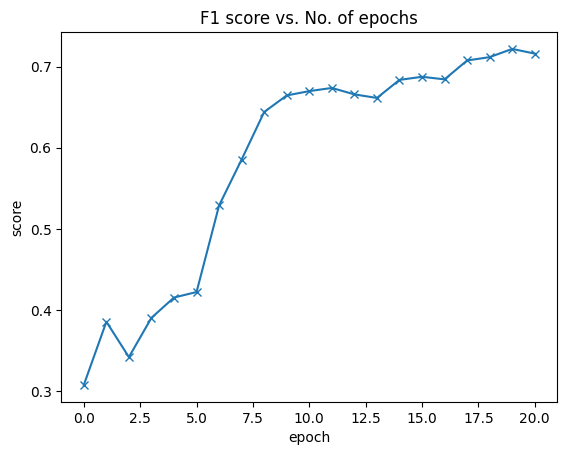

In [34]:
plot_scores(history)

In [35]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [36]:
test_df = pd.read_csv(TRAIN_CSV)
TEST_DIR = DATA_DIR + '/train'
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)

In [37]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  tensor([6.1683e-04, 3.1723e-03, 3.3804e-02, 1.7101e-03, 3.8244e-02, 1.9513e-02,
        2.4233e-03, 1.4176e-03, 1.0970e-03, 9.9092e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
Labels: Nuclear speckles(9)


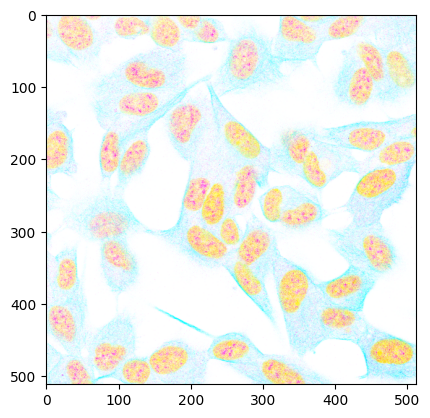

In [38]:
predict_single(test_dataset[0][0])

In [39]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [40]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [41]:
test_preds = predict_dl(test_dl, model)

  0%|          | 0/301 [00:00<?, ?it/s]

In [42]:
submission_df = pd.read_csv(TRAIN_CSV)
submission_df

,Image,Label
17054,18499,5
17117,22924,7
18971,12413,6
1492,22795,4
6688,21647,0
8778,27245,6
16441,21874,5
1134,18403,2 4
15593,11033,1 4
4491,29148,2


In [48]:
submission_df['Pred'] = test_preds

In [49]:
submission_df

,Image,Label,Pred
0,19567,9,9
1,29993,4 6,4 6
2,17186,3 4,3 4
3,29600,2 6,2 6
4,701,3 4,3 4
...,...,...,...
19231,428,6,6
19232,5342,7,7
19233,9806,4,4
19234,16112,5,5


In [50]:
submission_df.to_csv('ResNet_Pred.csv', index=False)

Prediction:  tensor([5.3881e-03, 3.4844e-05, 9.9972e-01, 1.8243e-01, 3.8592e-01, 2.0122e-03,
        5.6692e-01, 1.2013e-01, 1.0350e-03, 1.4031e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)
Labels: Nucleoli(2) Cytosol(6)
None


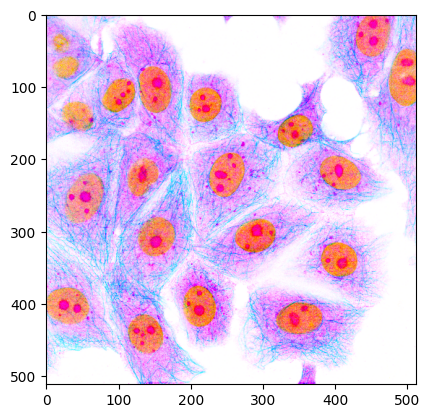

In [52]:
print(predict_single(test_dataset[3][0]))

In [53]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

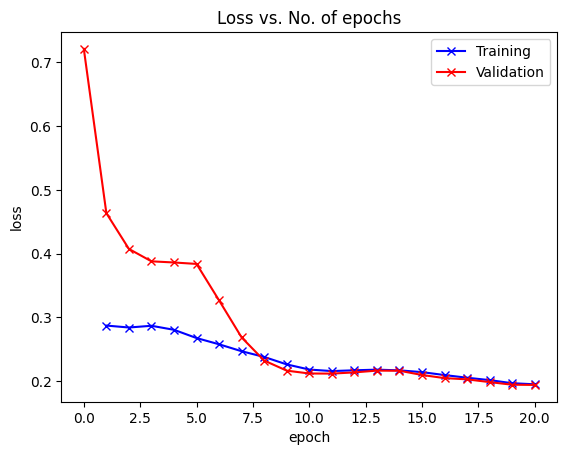

In [54]:
plot_losses(history)